In [1]:
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install matplotlib
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 19.4 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110703 sha256=56589deb39d9fb7dc3bf069d4cce081ce48eb4f3aec4a4db0fa022477e159e40
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle


In [2]:
# Import Library yang akan digunakan dan atau sekumpulan object Library yang tersedia pada python

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
from shutil import copyfile

%matplotlib inline

In [3]:
# download dataset and extract it
! export KAGGLE_USERNAME="ihratpramudya" && export KAGGLE_KEY="dd85cd2b7107f67135329e11e6b3243e" && kaggle datasets download --unzip smaranjitghose/corn-or-maize-leaf-disease-dataset
! ls

100%|████████████████████████████████████████| 161M/161M [00:05<00:00, 37.4MB/s]
100%|████████████████████████████████████████| 161M/161M [00:05<00:00, 28.9MB/s]
data  DatasetCorn


In [4]:
data_dir = '/home/wsuser/work/data/'

!mkdir DatasetCorn
# Direktori tujuan untuk menyimpan gambar-gambar yang telah difilter
destination_dir = '/home/wsuser/work/DatasetCorn/'

mkdir: cannot create directory ‘DatasetCorn’: File exists


In [5]:
# Daftar empat kelas yang dipilih
selected_classes = ['Blight', 'Gray_Leaf_Spot', 'Healthy']

# Membuat direktori untuk setiap kelas dalam direktori tujuan
for class_name in selected_classes:
    os.makedirs(os.path.join(destination_dir, class_name), exist_ok=True)

# Memindahkan gambar-gambar yang sesuai dengan empat kelas yang dipilih
for class_name in selected_classes:
    class_dir = os.path.join(data_dir, class_name)
    destination_class_dir = os.path.join(destination_dir, class_name)
    for filename in os.listdir(class_dir):
        source_path = os.path.join(class_dir, filename)
        destination_path = os.path.join(destination_class_dir, filename)
        copyfile(source_path, destination_path)

In [6]:
os.listdir(destination_dir)

['Blight', 'Healthy', 'Gray_Leaf_Spot']

In [7]:
# import Library unuk tahap preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
def display_image(class_name):
  """
  Display 10 Image from classes
  """
  plt.figure(figsize=(15, 15))
  for i in range(5):
    img = image.load_img(destination_dir + class_name + "/" + os.listdir(destination_dir + class_name)[i])
    plt.subplot(5, 5, i+1)
    plt.imshow(img)

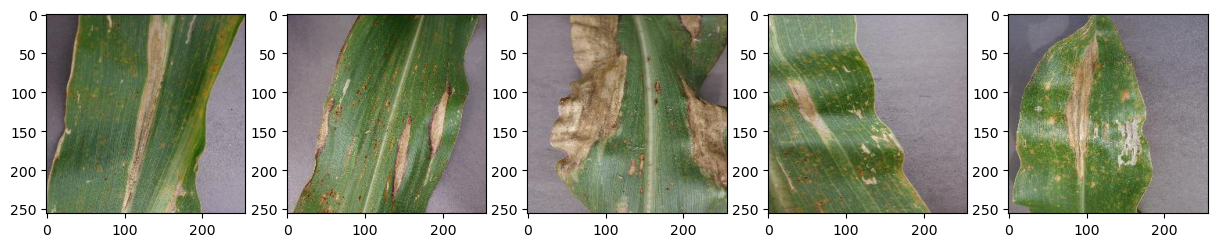

In [9]:
display_image('Blight')

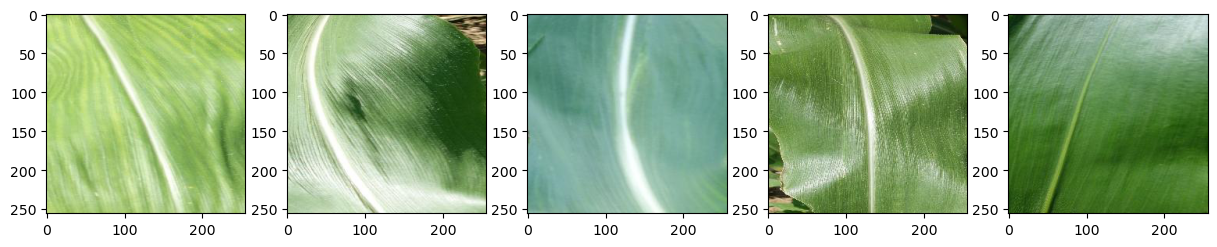

In [10]:
display_image('Healthy')

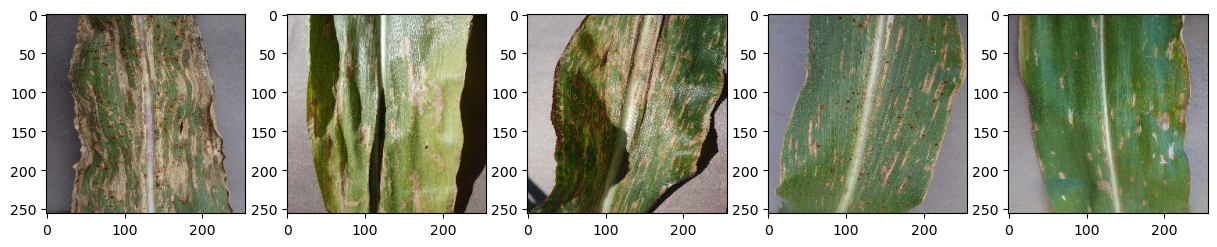

In [11]:
display_image('Gray_Leaf_Spot')

In [12]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [13]:
data_rice = tf.keras.preprocessing.image_dataset_from_directory(
    destination_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2882 files belonging to 3 classes.


In [14]:
class_names = data_rice.class_names
class_names

['Blight', 'Gray_Leaf_Spot', 'Healthy']

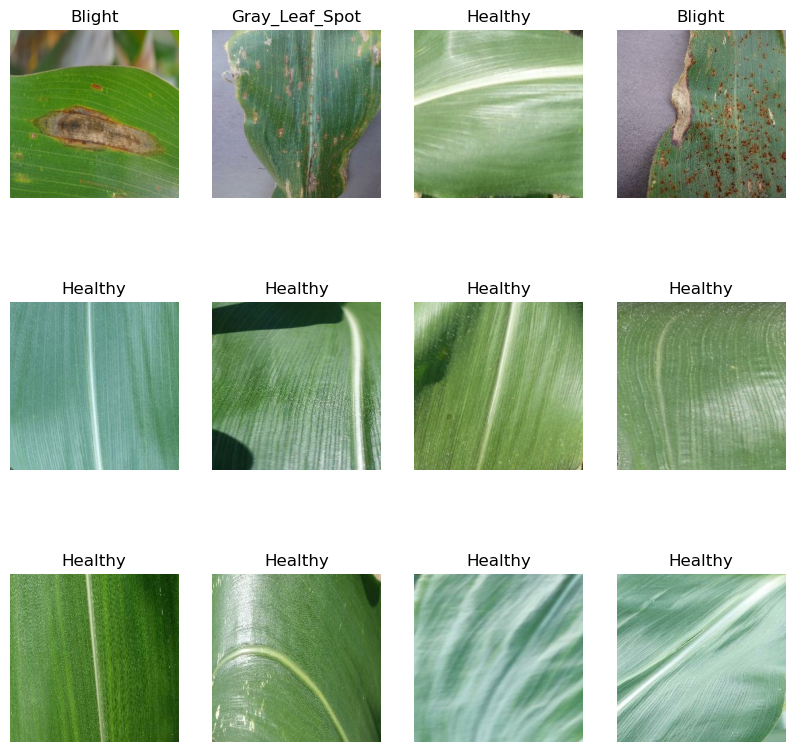

In [15]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data_rice.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [16]:
len(data_rice)

91

In [17]:
train_size = 0.8
len(data_rice)*train_size

72.8

In [18]:
train_size = 0.8
len(data_rice)*train_size

72.8

In [19]:
test_ds = data_rice.skip(72)
len(test_ds)

19

In [20]:
val_size=0.1
len(data_rice)*val_size

9.1

In [21]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [22]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data_rice)

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
72/72 [==============================] - 127s 2s/step - loss: 0.8340 - accuracy: 0.5976 - val_loss: 0.4848 - val_accuracy: 0.7847
Epoch 2/50
72/72 [==============================] - 113s 2s/step - loss: 0.4382 - accuracy: 0.7823 - val_loss: 0.4305 - val_accuracy: 0.7882
Epoch 3/50
72/72 [==============================] - 111s 2s/step - loss: 0.4161 - accuracy: 0.8039 - val_loss: 0.3837 - val_accuracy: 0.8056
Epoch 4/50
72/72 [==============================] - 113s 2s/step - loss: 0.4104 - accuracy: 0.7955 - val_loss: 0.3656 - val_accuracy: 0.7917
Epoch 5/50
72/72 [==============================] - 113s 2s/step - loss: 0.3547 - accuracy: 0.8166 - val_loss: 0.3509 - val_accuracy: 0.8160
Epoch 6/50
72/72 [==============================] - 113s 2s/step - loss: 0.4990 - accuracy: 0.7691 - val_loss: 0.4085 - val_accuracy: 0.8021
Epoch 7/50
72/72 [==============================] - 111s 2s/step - loss: 0.3622 - accuracy: 0.8201 - val_loss: 0.3966 - val_accuracy: 0.8021
Epoch 8/50
72

In [32]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 10s 368ms/step - loss: 0.1213 - accuracy: 0.9594


In [33]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

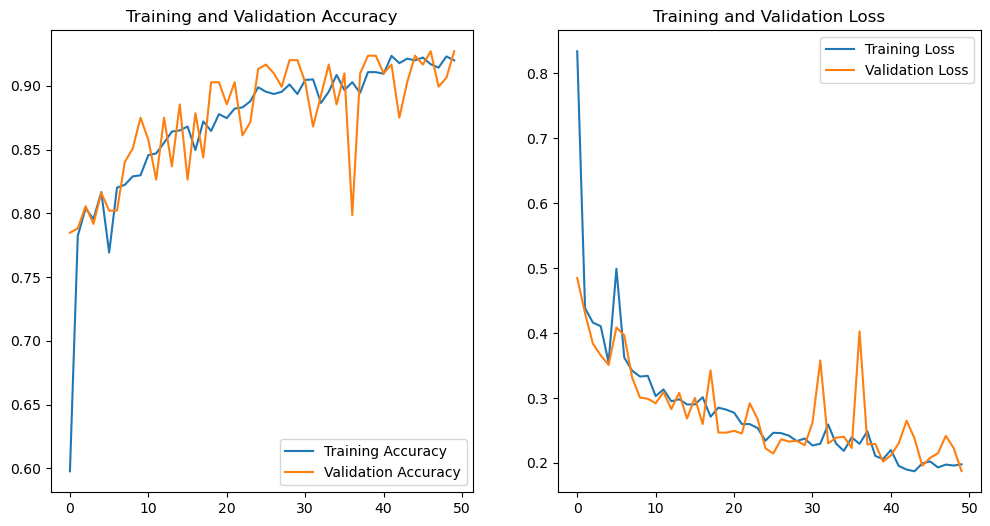

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
model.save("CornDetection.h5")